In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from data_cleaning import fill_missing_values, rename_columns
from data_science_skript import preprocess_data

from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler


from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import demographic_parity_difference



ModuleNotFoundError: No module named 'optuna'

In [3]:
df = pd.read_csv(r"C:\Kimi\Arbeit\Weiterbildung DADS\Stackfuel\Portfolio\PortfolioProject\.data\adult.csv", na_values=["?"]) 
df = fill_missing_values(df) 
df = rename_columns(df)

In [ ]:
# Diskriminierung beim Datensatz

plt.style.use('dark_background')  
colors = ["silver", "teal"]

# Einkommensverteilung nach Geschlecht
income_gender = df.groupby(['sex', 'income']).size().unstack()
income_gender.plot(kind='bar', stacked=True, color = colors, figsize=(8, 5))
plt.title("Einkommensverteilung nach Geschlecht")
plt.xlabel("Geschlecht")
plt.ylabel("Anzahl")
plt.xticks(rotation=0)
plt.legend(title="Einkommen")
plt.show()

# Einkommensverteilung nach Ethnie
income_race = df.groupby(['race', 'income']).size().unstack()
income_race.plot(kind='bar', stacked=True, color = colors, figsize=(10, 5))
plt.title("Einkommensverteilung nach Ethnie")
plt.xlabel("Ethnie")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.legend(title="Einkommen")
plt.show()


In [ ]:
# Demographic Parity für Geschlecht
gender_parity = df[df['income'] == '>50K']['sex'].value_counts(normalize=True)
print(gender_parity)

# Demographic Parity für Ethnie
race_parity = df[df['income'] == '>50K']['race'].value_counts(normalize=True)
print(race_parity)

In [ ]:
sns.pairplot(df)

Dies deutet auf starke Unterschiede in der Einkommensverteilung hin und muss beim Feature-Engeneering mit beachtet werden
- Geschlecht und Ethnie sollte als sensible Merkmale beachtet werden
- verschiedene Korkkekturne: Reweightung, Fairness Constraints

### Fairness in der Vorhersage messen:
- Falsch Positive und Falsch Negativ messen
- Disparate Impact Score = Rate der pos Ergebnisse für die benachteiligten Gruppe / Rate der pos Ergebnisse für die bevorzugte Gruppe (>0.8)

# Modellauswahl
- Logistisches Modell 
- Decision Tree
- Random Forest
- Neuronale Netze?
### Fairness-optimierte Modelle
- Fair Logistic Regression

In [4]:
# Variablen umwandeln
df = preprocess_data(df)

In [ ]:
df_numeric = df.select_dtypes(include=["int64"])
sns.heatmap(df_numeric.corr(),cmap="plasma", vmax=0.8)

### Bewertung der Feature-Correlation
- education_num
- age
- sex, hours_per_week, age, income scheinen eine gewisse Korrelation zu haben

In [5]:
# Train-Test-Split
target = df["income"]
features = df.drop(columns=["income"])

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=target)

In [ ]:
print("Trainingsdaten:\n",features_train.shape)
print("\nTestdaten:\n",features_test.shape)

In [ ]:
df.dtypes

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=target_train, ax=ax[0])
ax[0].set_title("Klassenverteilung im Training-Set")

sns.countplot(x=target_test, ax=ax[1])
ax[1].set_title("Klassenverteilung im Test-Set")

plt.show()



In [ ]:
train_crosstab_income = pd.crosstab(index=target_train, columns = "count", normalize = "columns")
test_crosstab_income = pd.crosstab(index=target_test, columns = "count", normalize = "columns")
display(train_crosstab_income)
display(test_crosstab_income)

### Kalssenverteilung
Es ist ein deutliches Ungleichgewicht der Zielkategorie zu erkennen:
- class_weight = balanced
- SMOTE

In [6]:
# Vorbereitung
num_cols = features_train.select_dtypes(include=["int64"]).columns
cat_cols = features_train.select_dtypes(include=["object"]).columns 

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

# Baselinemodell Logistische Regression

pipeline_log_base = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", random_state = 42))
     ])

pipeline_log_base.fit(features_train,target_train)
target_pred_log_base = pipeline_log_base.predict(features_test)

print("Accuracy", accuracy_score(target_test, target_pred_log_base))
print("Classification report\n", classification_report(target_test, target_pred_log_base))

Accuracy 0.8085367726086289
Classification report
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      4945
           1       0.57      0.85      0.68      1568

    accuracy                           0.81      6513
   macro avg       0.76      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513



# Erste Bewertung 
Das Modell zeigt eine klare Diskriminierung:

### Precision
    - Einkommen > 50K werden ungenauer (nur mit 57% Wahrscheinlichkeit richtig vorhergesagt)
    --> Diskriminierung gegen zu hoch verdienende ?

### Recall
    - relativ gut und ausgeglichen

### F1-Score
    - auch hier werden Hochverdiener deutlich schlechter erkannt

### Ursachen:
- Datenungleichgewicht
- Feature Bias
- andere Modelle können eventuell besser unterscheiden (RandomForest)


In [ ]:
features_train.columns

In [7]:
# Feature-Anpassung

crit_cols = ["sex", "race"]
features_train_crit = features_train.drop(columns=crit_cols)
features_test_crit = features_test.drop(columns=crit_cols)

num_cols_crit = features_train_crit.select_dtypes(include=["int64"]).columns
cat_cols_crit = features_train_crit.select_dtypes(include=["object"]).columns 

preprocessor_crit = ColumnTransformer([
    ("num", StandardScaler(), num_cols_crit),
    ("cat", OneHotEncoder(), cat_cols_crit)
])

pipeline_log_base_crit = Pipeline([
    ("preprocessor", preprocessor_crit),
    ("model", LogisticRegression(class_weight="balanced", random_state = 42))
     ])

pipeline_log_base_crit.fit(features_train_crit, target_train)
target_pred_log_base_crit = pipeline_log_base_crit.predict(features_test_crit)

print("LogistischeRegression\n", classification_report(target_test, target_pred_log_base_crit))

LogistischeRegression
               precision    recall  f1-score   support

           0       0.94      0.79      0.86      4945
           1       0.57      0.85      0.68      1568

    accuracy                           0.81      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513



In [ ]:
# Feature-Importance des Base-Line Modells
feature_names = list(num_cols) + list(pipeline_log_base.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols))
coefficients = pipeline_log_base.named_steps["model"].coef_[0]
feature_importance = pd.Series(data = pipeline_log_base.named_steps["model"].coef_[0],
                               index = feature_names).sort_values(ascending=False)
# Feature Importance OHNE sex and race
feature_names_crit = list(num_cols_crit) + list(pipeline_log_base_crit.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols_crit))
coefficients_crit = pipeline_log_base_crit.named_steps["model"].coef_[0]
feature_importance_crit = pd.Series(data = pipeline_log_base_crit.named_steps["model"].coef_[0],
                               index = feature_names_crit).sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10)) 
feature_importance.head(20).plot(kind='barh', ax = ax[0])
feature_importance_crit.head(20).plot(kind='barh', ax = ax[1])

ax[0].set_title("Feature Importance mit allen Features")
ax[1].set_title("Feature Importance ohne 'sex' und 'race'")



### Bewertung der Feature-Importance
- Herkunftsländer scheinen eine auffällig große Rolle zu spielen
- das Geschlecht und die Rasse dafür nicht direkt.
- --> es gibt aber andere Metriken, die indirekt auf ein Geschlecht hinweisen(Education, Occupation, Relationship)

In [8]:
# Fairness-Metriken berechnen für Geschlecht: 0 - Female / 1- Male

for group in features_test["sex"].unique():
    mask = (features_test["sex"] == group)
    acc = accuracy_score(target_test[mask], target_pred_log_base[mask])
    prec = precision_score(target_test[mask], target_pred_log_base[mask])
    rec = recall_score(target_test[mask], target_pred_log_base[mask])

    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

0 - Accuracy: 0.913, Precision: 0.622, Recall: 0.740
1 - Accuracy: 0.756, Precision: 0.560, Recall: 0.872


In [ ]:
# Fairness-Metriken für Ethnie

for group in features_test["race"].unique():  
    mask = (features_test["race"] == group)  
    
    acc = accuracy_score(target_test[mask], target_pred_log_base[mask])
    prec = precision_score(target_test[mask], target_pred_log_base[mask])
    rec = recall_score(target_test[mask], target_pred_log_base[mask])
    
    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

# Fazit zum ersten Baselinemodell Logistische Regression
## Geschlecht

#### Leichte Diskriminierung erkennbar:
Recall (Female: 74,7%, Male: 86,7%)
- Frauen, die tatsächlich Hochverdiener sind, werden schlechter erkannt (niedrigerer Recall)
- Männer haben einen höheren Recall, das heißt Männer werden besser als Hochverdiener erkannt

Accuracy (Female: 91,3%, Male: 75,6%):
- Frauen werden besser klassifiziert als Männer:
    - die meisten Frauen sind in der Kategorie <=50K
    - weitere Features deuten auf Frauen hin (Relationship)

Precision (Female: 59,8%, Male: 56,4%):
- Ergebnisse sind sehr ähnlich

## Ethnie
- Das Modell erkennt Hochverdiener aus bestimmten ethnischen Gruppen schlechter:
    - Recall für White besonders gut (85,8%) im Gegensatz zu indigenen und "other"
    - Precision für Indigene besonders schlecht
    -Precision für Other extrem gut - Datenset-Problem?

In [9]:
# DecisionTree
# Modell
pipeline_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

#Anpassen des Modells
pipeline_dt.fit(features_train, target_train)

#Vorhersage
target_pred_dt = pipeline_dt.predict(features_test)

#Kennzahlen
print("DecisionTree:\n", classification_report(target_test, target_pred_dt))

DecisionTree:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      4945
           1       0.61      0.64      0.62      1568

    accuracy                           0.81      6513
   macro avg       0.75      0.75      0.75      6513
weighted avg       0.82      0.81      0.82      6513



In [10]:
# RandomForest
# Modell
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=42))
])

#Anpassen des Modells
pipeline_rf.fit(features_train, target_train)

#Vorhersage
target_pred_rf = pipeline_rf.predict(features_test)

#Kennzahlen
print("RandomForest:\n", classification_report(target_test, target_pred_rf))

RandomForest:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.74      0.62      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513



Text(0.5, 1.0, 'Feature Importance Random Forest')

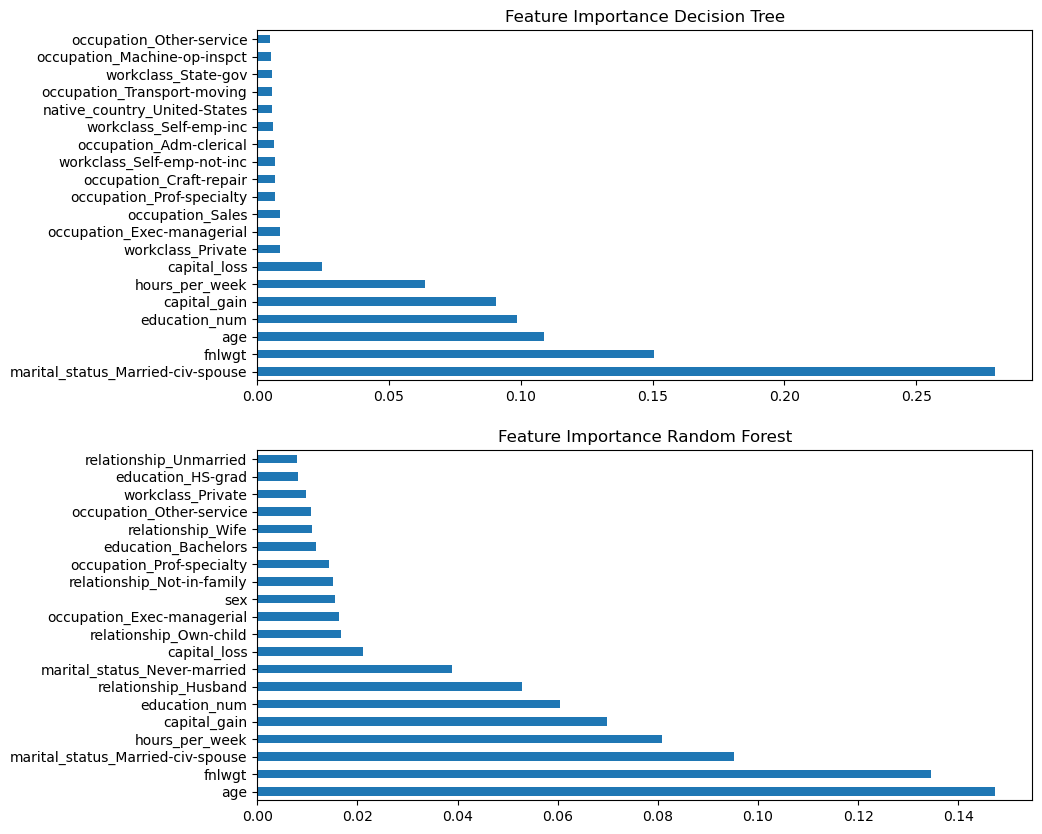

In [11]:
# Feature Importance
feature_names = list(num_cols) + list(pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols))

# Für den DecisionTree
feature_importance_dt = pd.Series(data=pipeline_dt.named_steps["model"].feature_importances_,
                               index=feature_names).sort_values(ascending=False)

#RandomForest
feature_importance_rf = pd.Series(data=pipeline_rf.named_steps["model"].feature_importances_,
                               index=feature_names).sort_values(ascending=False)


# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10)) 
feature_importance_dt.head(20).plot(kind='barh', ax = ax[0])
feature_importance_rf.head(20).plot(kind='barh', ax = ax[1])

ax[0].set_title("Feature Importance Decision Tree")
ax[1].set_title("Feature Importance Random Forest")

In [12]:
# Fairness-Metriken für DecisionTree
# Fairness-Metriken berechnen für Geschlecht: 0 - Female / 1- Male
print("DecisionTree")
for group in features_test["sex"].unique():
    mask = (features_test["sex"] == group)
    acc = accuracy_score(target_test[mask], target_pred_dt[mask])
    prec = precision_score(target_test[mask], target_pred_dt[mask])
    rec = recall_score(target_test[mask], target_pred_dt[mask])

    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

print("\n")
for group in features_test["race"].unique():  
    mask = (features_test["race"] == group)  
    
    acc = accuracy_score(target_test[mask], target_pred_dt[mask])
    prec = precision_score(target_test[mask], target_pred_dt[mask])
    rec = recall_score(target_test[mask], target_pred_dt[mask])
    
    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

DecisionTree
0 - Accuracy: 0.891, Precision: 0.555, Recall: 0.565
1 - Accuracy: 0.775, Precision: 0.619, Recall: 0.652


White - Accuracy: 0.805, Precision: 0.612, Recall: 0.640
Black - Accuracy: 0.888, Precision: 0.610, Recall: 0.562
Indigenous - Accuracy: 0.871, Precision: 0.300, Recall: 0.750
Asian-Pac-Islander - Accuracy: 0.808, Precision: 0.597, Recall: 0.685
Other - Accuracy: 0.833, Precision: 0.455, Recall: 0.556


In [ ]:
# Fairness-Metriken für RandomForest
# Fairness-Metriken berechnen für Geschlecht: 0 - Female / 1- Male
print("RandomForest")
for group in features_test["sex"].unique():
    mask = (features_test["sex"] == group)
    acc = accuracy_score(target_test[mask], target_pred_rf[mask])
    prec = precision_score(target_test[mask], target_pred_rf[mask])
    rec = recall_score(target_test[mask], target_pred_rf[mask])

    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

print("\n")
for group in features_test["race"].unique():  
    mask = (features_test["race"] == group)  
    
    acc = accuracy_score(target_test[mask], target_pred_rf[mask])
    prec = precision_score(target_test[mask], target_pred_rf[mask])
    rec = recall_score(target_test[mask], target_pred_rf[mask])
    
    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

In [ ]:
print("LogisticRegression:\n", accuracy_score(target_test, target_pred_log_base), precision_score(target_test, target_pred_log_base), recall_score(target_test, target_pred_log_base))
print("DecisionTree:\n", accuracy_score(target_test, target_pred_dt), precision_score(target_test, target_pred_dt), recall_score(target_test, target_pred_dt))
print("RandomForest:\n", accuracy_score(target_test, target_pred_rf), precision_score(target_test, target_pred_rf), recall_score(target_test, target_pred_rf))

### Bewertung der einzelnen Basismodelle
|Modell | Accuracy | Precision | Recall|
|:------|:---------|:----------|:------|
|Logistische Regression|0.808|0.568|0.848|
|DecisionTree|0.815|0.619|0.605|
|RandomForest|0.856|0.748|0.607|

Aufgrund dieser Werte werde ich mich weiter dem RandomForest widmen, da dies die zuverlässigsten Ergebnisse liefert (hohe Precision) und hohe Gesamtgenauigkeit

## Implementierung von SMOTE, um den Bias weiter zu reduzieren

In [13]:
pipeline_rf_smote = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(sampling_strategy="auto", random_state=42)),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=42))
])

pipeline_rf_smote.fit(features_train, target_train)

target_pred_rf_smote = pipeline_rf_smote.predict(features_test)

print("Classification Report Random Forest with SMOTE:\n", classification_report(target_test, target_pred_rf_smote))
print("RandomForest mit SMOTE:\n", accuracy_score(target_test, target_pred_rf_smote), precision_score(target_test, target_pred_rf_smote), recall_score(target_test, target_pred_rf_smote))


Classification Report Random Forest with SMOTE:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      4945
           1       0.68      0.70      0.69      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.80      0.79      6513
weighted avg       0.85      0.85      0.85      6513

RandomForest mit SMOTE:
 0.8464609243052357 0.6759603469640645 0.6957908163265306


#### Bewertung SMOTE
|Modell | Accuracy | Precision | Recall|
|:------|:---------|:----------|:------|
|RandomForest|0.856|0.748|0.607|
|RandomForest SMOTE|0.845|0.675|0.688|


In [ ]:
# Fairness-Metriken Equalized Odds Difference für RandomForest
eq_odds_diff_sex = equalized_odds_difference(y_true = target_test, 
                                               y_pred = target_pred_rf,
                                           sensitive_features= features_test["sex"])

eq_odds_diff_race = equalized_odds_difference(y_true = target_test, 
                                               y_pred = target_pred_rf,
                                           sensitive_features= features_test["race"])

print(f"\nEqualized Odds Difference (EOD) für 'sex': {eq_odds_diff_sex:.4f}")
print(f"\nEqualized Odds Difference (EOD) für 'race': {eq_odds_diff_race:.4f}")


Equalized Odds Difference (EOD) für 'sex': 0.1038

Equalized Odds Difference (EOD) für 'race': 0.1866


In [26]:
# Fairness-Metriken Equalized Odds Difference für RandomForest mit SMOTE
eq_odds_diff_sex = equalized_odds_difference(y_true = target_test, 
                                               y_pred = target_pred_rf_smote,
                                           sensitive_features= features_test["sex"])

eq_odds_diff_race = equalized_odds_difference(y_true = target_test, 
                                               y_pred = target_pred_rf_smote,
                                           sensitive_features= features_test["race"])

print(f"\nEqualized Odds Difference (EOD) für 'sex': {eq_odds_diff_sex:.4f}")
print(f"\nEqualized Odds Difference (EOD) für 'race': {eq_odds_diff_race:.4f}")


Equalized Odds Difference (EOD) für 'sex': 0.1219

Equalized Odds Difference (EOD) für 'race': 0.3056


In [19]:
# Fairness-Metriken Equalized Odds Difference für DecisionTree
eq_odds_diff_sex = equalized_odds_difference(y_true = target_test, 
                                               y_pred = target_pred_dt,
                                           sensitive_features= features_test["sex"])

eq_odds_diff_race = equalized_odds_difference(y_true = target_test, 
                                               y_pred = target_pred_dt,
                                           sensitive_features= features_test["race"])

print(f"\nEqualized Odds Difference (EOD) für 'sex': {eq_odds_diff_sex:.4f}")
print(f"\nEqualized Odds Difference (EOD) für 'race': {eq_odds_diff_race:.4f}")


Equalized Odds Difference (EOD) für 'sex': 0.1085

Equalized Odds Difference (EOD) für 'race': 0.1944


In [20]:
# Fairness-Metriken Equalized Odds Difference für Logistische Regression
eq_odds_diff_sex = equalized_odds_difference(y_true = target_test, 
                                               y_pred = target_pred_log_base,
                                           sensitive_features= features_test["sex"])

eq_odds_diff_race = equalized_odds_difference(y_true = target_test, 
                                               y_pred = target_pred_log_base,
                                           sensitive_features= features_test["race"])

print(f"\nEqualized Odds Difference (EOD) für 'sex': {eq_odds_diff_sex:.4f}")
print(f"\nEqualized Odds Difference (EOD) für 'race': {eq_odds_diff_race:.4f}")


Equalized Odds Difference (EOD) für 'sex': 0.2309

Equalized Odds Difference (EOD) für 'race': 0.3333


In [22]:
#Fairness-Metriken Demographic Parity Difference für RandomForest
dp_diff_sex = demographic_parity_difference(
    y_pred=target_pred_rf, 
    y_true=target_test,
    sensitive_features=features_test["sex"])
                                     
dp_diff_race = demographic_parity_difference(
    y_pred=target_pred_rf, 
    y_true=target_test,
    sensitive_features=features_test["race"])

print(f"\nDemographic Parity Difference für 'sex': {dp_diff_sex:.4f}")
print(f"Demographic Parity Difference für 'race': {dp_diff_race:.4f}")


Demographic Parity Difference für 'sex': 0.1753
Demographic Parity Difference für 'race': 0.1387


In [25]:
#Fairness-Metriken Demographic Parity Difference für RandomForest mit SMOTE
dp_diff_sex = demographic_parity_difference(
    y_pred=target_pred_rf_smote, 
    y_true=target_test,
    sensitive_features=features_test["sex"])
                                     
dp_diff_race = demographic_parity_difference(
    y_pred=target_pred_rf_smote, 
    y_true=target_test,
    sensitive_features=features_test["race"])

print(f"\nDemographic Parity Difference für 'sex': {dp_diff_sex:.4f}")
print(f"Demographic Parity Difference für 'race': {dp_diff_race:.4f}")


Demographic Parity Difference für 'sex': 0.2182
Demographic Parity Difference für 'race': 0.1842


In [23]:
#Fairness-Metriken Demographic Parity Difference für DecisionTree
dp_diff_sex = demographic_parity_difference(
    y_pred=target_pred_dt, 
    y_true=target_test,
    sensitive_features=features_test["sex"])
                                     
dp_diff_race = demographic_parity_difference(
    y_pred=target_pred_dt, 
    y_true=target_test,
    sensitive_features=features_test["race"])

print(f"\nDemographic Parity Difference für 'sex': {dp_diff_sex:.4f}")
print(f"Demographic Parity Difference für 'race': {dp_diff_race:.4f}")


Demographic Parity Difference für 'sex': 0.1909
Demographic Parity Difference für 'race': 0.1534


In [24]:
#Fairness-Metriken Demographic Parity Difference für LogistischeRegression
dp_diff_sex = demographic_parity_difference(
    y_pred=target_pred_log_base, 
    y_true=target_test,
    sensitive_features=features_test["sex"])
                                     
dp_diff_race = demographic_parity_difference(
    y_pred=target_pred_log_base, 
    y_true=target_test,
    sensitive_features=features_test["race"])

print(f"\nDemographic Parity Difference für 'sex': {dp_diff_sex:.4f}")
print(f"Demographic Parity Difference für 'race': {dp_diff_race:.4f}")


Demographic Parity Difference für 'sex': 0.3213
Demographic Parity Difference für 'race': 0.2760


### Bewertung der Fairness-Metriken:
Kurzfassung:
Randomforest schneidet am besten ab mit class_weight = balanced

Langfassung ***********